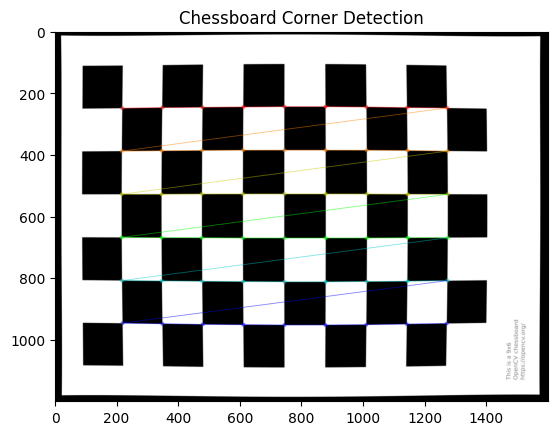


Recovered Calibration Matrix:
 [[3.40193859e+03 0.00000000e+00 8.05921429e+02]
 [0.00000000e+00 3.60706370e+03 5.96342106e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Recovered Distortion Coefficients:
 [[-1.01219663e+00  1.36936267e+01 -3.04750283e-03 -4.65615231e-03
  -1.02000226e+02]]


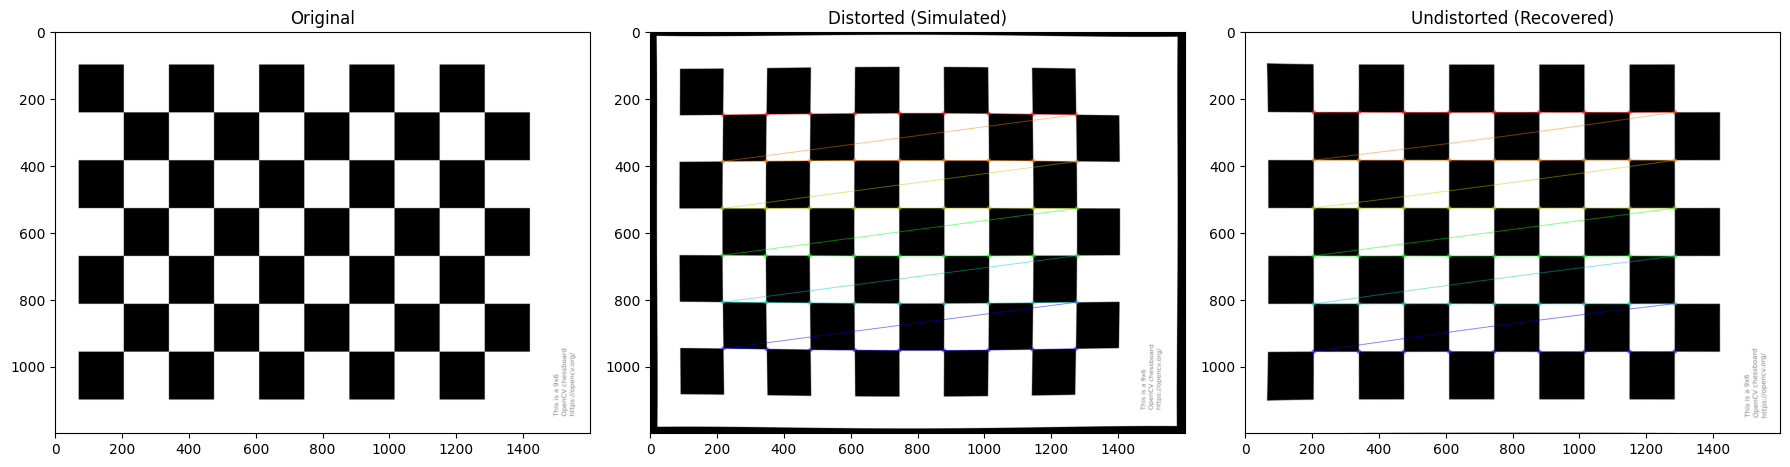

In [54]:
# 📸 Synthetic Camera Distortion and Calibration Demo

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('chessboard_images/chessboard.png')
img = cv2.resize(img, (1600, 1200))  # Ensure large enough resolution
h, w = img.shape[:2]

# Simulate camera intrinsics
focal_length = 800
cx, cy = w / 2, h / 2
K_sim = np.array([[focal_length, 0, cx],
                  [0, focal_length, cy],
                  [0, 0, 1]])

# Simulate distortion coefficients
# Positive k1 creates barrel distortion
# Mild distortion values for recoverability
dist_coeffs_sim = np.array([0.05, -0.02, 0.001, 0.001, 0.0])

# Step 1: Distort the original image using remap
map1, map2 = cv2.initUndistortRectifyMap(K_sim, dist_coeffs_sim, None, K_sim, (w, h), cv2.CV_32FC1)
distorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR)

# Step 2: Undistort the distorted image using the same simulated values
undistorted_img = cv2.undistort(distorted_img, K_sim, dist_coeffs_sim)

# Step 3: Simulate Calibration on Distorted Image
# Use known object and image points from a chessboard
chessboard_size = (9, 6)
square_size = 1.0
objp = np.zeros((np.prod(chessboard_size), 3), np.float32)
objp[:, :2] = np.indices(chessboard_size).T.reshape(-1, 2)
objp *= square_size
objpoints = []
imgpoints = []

gray = cv2.cvtColor(distorted_img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
if ret:
    refined_corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 30, 0.001))
    objpoints.append(objp)
    imgpoints.append(refined_corners)
    cv2.drawChessboardCorners(distorted_img, chessboard_size, refined_corners, ret)
    plt.imshow(cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB))
    plt.title("Chessboard Corner Detection")
    plt.show()
    # Calibrate using distorted image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print("\nRecovered Calibration Matrix:\n", mtx)
    print("Recovered Distortion Coefficients:\n", dist)

    # Undistort again using recovered calibration
    recovered = cv2.undistort(distorted_img, mtx, dist)
else:
    print("❌ Chessboard corners not detected. Calibration skipped.")
    recovered = np.zeros_like(distorted_img)

# Visualize all results
plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Original")
plt.subplot(132), plt.imshow(cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB)), plt.title("Distorted (Simulated)")
plt.subplot(133), plt.imshow(cv2.cvtColor(recovered, cv2.COLOR_BGR2RGB)), plt.title("Undistorted (Recovered)")
plt.tight_layout()
plt.show()
